In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import pyfolio as pf

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 200

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Backtesting

This notebook will cover [backtesting](https://www.investopedia.com/terms/b/backtesting.asp#:~:text=Backtesting%20is%20the%20general%20method,to%20employ%20it%20going%20forward.), which allows the user to assess the viability of a strategy based on [historical data](https://github.com/sweetscientist/quantitative_finance/blob/master/stock_data_collection.ipynb). The base logic is that if something worked well in the past then it will most likely work well in the future as well and vice versa. Like any predicting modelling it is suggested to reserve a time period for training and testing to confirm it's stability

#### Download the data

First things first, we need to bring in our data. This may determine the flow later on so it is usually better to figure out what shape the data should be first. In our case, the backtesting library takes in a [pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html) with columns 'Open', 'High', 'Low', 'Close' and/or 'Volume'. This is also achievable using [pandas-datareader](https://pandas-datareader.readthedocs.io/en/latest/), [Quandl](https://www.quandl.com/tools/python), [findatapy](https://github.com/cuemacro/findatapy). If you have tried the others and works well with your strategy please share the advantages of that framework.

Text(0.5, 1.0, 'SPY Closing Price')

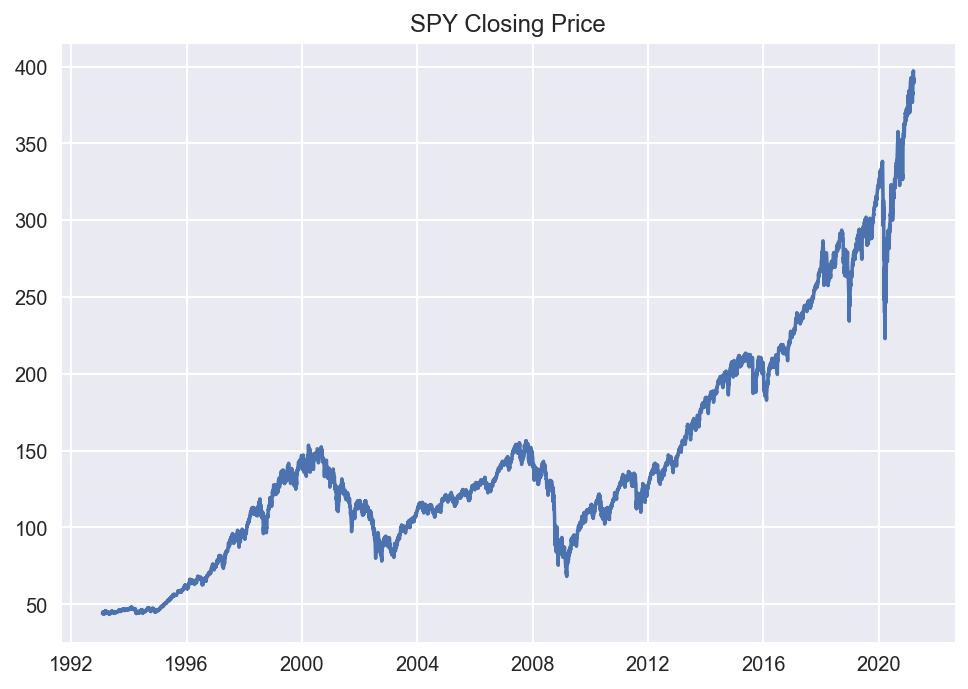

In [119]:
import yfinance as yf

ticker = 'SPY'
df = yf.download(ticker, progress=False) # without the dates returns all possible
plt.style.use('seaborn')
plt.plot(df.Close)
plt.title(ticker+' Closing Price')

#### Create a strategy

The following example is a simple strategy using moving average cross over. Here we will use indicators such as [simple moving average(SMA)](https://school.stockcharts.com/doku.php?id=technical_indicators:moving_averages) & [exponential moving average(EMA)](https://school.stockcharts.com/doku.php?id=technical_indicators:moving_averages). First we'll build the strategy using an arbitrary window for the moving averages(MA) and then move on to optimizing the window for MA to see if the performance is better. 

Note:
- [EMA](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.ewm.html) here considers a single method of adjusting the weights. 
- [Strategy](https://kernc.github.io/backtesting.py/doc/examples/Quick%20Start%20User%20Guide.html)
 adopted from backtesting doumentation

In [185]:
from backtesting import Strategy
from backtesting.lib import crossover

def SMA(data, n):
    return pd.Series(data).rolling(n).mean()

def EMA(data, n):
    return pd.Series(data).ewm(com=n, adjust=False).mean()

class Cross(Strategy):
    # Define the two MA lags as *class variables*
    # for later optimization
    n1 = 100
    n2 = 150
    
    def init(self):
        # Precompute the two moving averages
        self.sma = self.I(SMA, self.data.Close, self.n1)
        self.ema = self.I(EMA, self.data.Close, self.n2)
    
    def next(self):
        # If sma crosses above ema, close any existing
        # short trades, and buy the asset
        if crossover(self.sma, self.ema):
            self.position.close()
            self.buy()

        # Else, if ema crosses below sma, close any existing
        # long trades, and sell the asset
        elif crossover(self.ema, self.sma):
            self.position.close()
            self.sell()

#### Get backtest stats

In [186]:
bt = Backtest(df, Cross, cash=10000, commission=.002)

stats = bt.run()
stats

Start                     1993-01-29 00:00:00
End                       2021-03-24 00:00:00
Duration                  10281 days 00:00:00
Exposure Time [%]                   94.851178
Equity Final [$]                119903.459134
Equity Peak [$]                 121819.022122
Return [%]                        1099.034591
Buy & Hold Return [%]              789.445207
Return (Ann.) [%]                    9.232115
Volatility (Ann.) [%]                18.08642
Sharpe Ratio                         0.510445
Sortino Ratio                           0.798
Calmar Ratio                         0.270922
Max. Drawdown [%]                   -34.07669
Avg. Drawdown [%]                   -2.254924
Max. Drawdown Duration     1606 days 00:00:00
Avg. Drawdown Duration       33 days 00:00:00
# Trades                                   16
Win Rate [%]                            68.75
Best Trade [%]                     190.377592
Worst Trade [%]                     -8.541674
Avg. Trade [%]                    

#### Plot the results

In [187]:
bt.plot()

Looking at the sharpe ratio of 0.5 this strategy seems to be sub-optimal even if it was executed on point for almost 30 years. In this case we can go back to the drawing board and come up with a new strategy or try to tune our parameters and see if we can improve our results

#### Optimizing parameters 
The following uses the [optimize](https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#backtesting.backtesting.Backtest.optimize) method to search through a grid of values and find the best parameters where the 'Sharpe Ratio' is maximized. 

In [188]:
stats = bt.optimize(n1=range(100, 200, 50),
                    n2=range(100, 300, 50),
                    maximize='Sharpe Ratio',
                    constraint=lambda param: param.n1 < param.n2)
stats

/Users/benlee/opt/anaconda3/envs/qf/lib/python3.9/site-packages/backtesting/backtesting.py:1361: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


Start                     1993-01-29 00:00:00
End                       2021-03-24 00:00:00
Duration                  10281 days 00:00:00
Exposure Time [%]                   94.724221
Equity Final [$]                137091.305145
Equity Peak [$]                 140547.789913
Return [%]                        1270.913051
Buy & Hold Return [%]              789.445207
Return (Ann.) [%]                    9.753522
Volatility (Ann.) [%]               18.054408
Sharpe Ratio                         0.540229
Sortino Ratio                         0.84961
Calmar Ratio                         0.286266
Max. Drawdown [%]                  -34.071578
Avg. Drawdown [%]                   -2.211058
Max. Drawdown Duration     1457 days 00:00:00
Avg. Drawdown Duration       32 days 00:00:00
# Trades                                   12
Win Rate [%]                        66.666667
Best Trade [%]                     184.064013
Worst Trade [%]                       -8.4509
Avg. Trade [%]                    

In [189]:
stats._strategy

<Strategy Cross(n1=100,n2=200)>

In [190]:
bt.plot(plot_volume=False, plot_pl=False)

After the optimization we increase our sharpe ratio from 0.51 to 0.54, which is not a significant increase, but by running the optimization the final equity increases and the draw down duration is shortened as well. This is both expected and accepted as the strategy is simple and not necessarily built with any application intentions. However, looking at the charts along with some experimentation shows that it's better to constantly buy SPY and hold rather than actively trade on a daily to weekly basis. This observation reminded me much of the book ["A Random Walk Down Wall Street"](https://www.amazon.com/Random-Walk-Down-Wall-Street/dp/0393358380/ref=asc_df_0393358380/?tag=hyprod-20&linkCode=df0&hvadid=459680637280&hvpos=&hvnetw=g&hvrand=3105767800781207743&hvpone=&hvptwo=&hvqmt=&hvdev=c&hvdvcmdl=&hvlocint=&hvlocphy=9010813&hvtargid=pla-864572942049&psc=1).